<a href="https://colab.research.google.com/github/Xinsen-Zhang/torch-study/blob/master/11_adaDelta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# adaDelta
$$s:=\rho s + (1-\rho) g^2$$
$$g' := \frac{\sqrt{\Delta \theta + \epsilon}}{\sqrt{s + \epsilon}} g$$
$$\Delta \theta := \rho \Delta \theta + (1-\rho) g'^2$$
$$\theta:= \theta - g'$$

In [0]:
import numpy as np
import torch
from torchvision.datasets import MNIST #	
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def adaDelta(parameters, sqrs, deltas, rho):
    eps= 1e-6
    for param, sqr, delta in zip(parameters, sqrs, deltas):
        sqr[:] = rho * sqr + (1 - rho) * param.grad.data ** 2
        cur_delta = torch.sqrt(delta + eps) / torch.sqrt(sqr + eps) * param.grad.data
        delta[:] = rho * delta + (1- rho) * cur_delta ** 2
        param.data = param.data - cur_delta

In [0]:
def data_tf(x):
    x = np.array(x, dtype= 'float32') / 255
    x = (x- 0.5) / 0.5
    x = x.reshape((-1,))
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train= True, transform= data_tf, download= True)

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [20]:
train_data = DataLoader(train_set, batch_size= 64, shuffle= True)
# 定义三层网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 把net 搬到gpu上
net.cuda()

# 初始化sqrs 和 deltas
sqrs = []
deltas = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data).cuda())
    deltas.append(torch.zeros_like(param.data).cuda())

# 开始训练
losses = []
idx = 0
start = time.time()
for e in range(10):
    train_loss = 0
    for im,label in train_data:
        im = Variable(im.float()).cuda()
        label = Variable(label).cuda()
        # forwards
        out = net(im)
        loss = criterion(out, label)
        # backwards
        net.zero_grad()
        loss.backward()
        adaDelta(net.parameters(), sqrs, deltas, 0.9) # rho 设置为0.9
        # 记录误差
        train_loss += loss.data
        if(idx % 50 == 0):
            losses.append(loss.data)
        idx += 1
    print('epoch: {}, Train Loss: {:.5f}'.format(e +1, loss.data))
end = time.time()
print('使用时间:{:.5f} s'.format(end - start))

epoch: 1, Train Loss: 0.21589
epoch: 2, Train Loss: 0.29956
epoch: 3, Train Loss: 0.40982
epoch: 4, Train Loss: 0.27723
epoch: 5, Train Loss: 0.07634
epoch: 6, Train Loss: 0.00624
epoch: 7, Train Loss: 0.02419
epoch: 8, Train Loss: 0.09444
epoch: 9, Train Loss: 0.00707
epoch: 10, Train Loss: 0.02352
使用时间:80.92271 s


In [0]:
x_axis = np.linspace(0, 10, len(losses), endpoint= True)

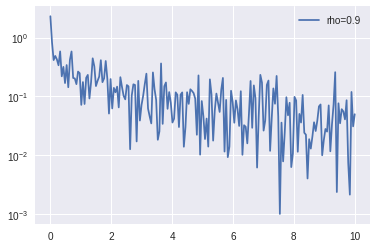

In [24]:
plt.semilogy(x_axis, losses, label= 'rho=0.9')
plt.legend(loc= 'best')

# 内置的AdaDelta

In [23]:
train_data = DataLoader(train_set, batch_size= 64, shuffle= True)
# 定义三层网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 把net 搬到gpu上
net.cuda()

# 定义优化器
optimizer = torch.optim.Adadelta(net.parameters(), rho= 0.9)

# 开始训练
losses1 = []
idx = 0
start = time.time()
for e in range(10):
    train_loss = 0
    for im,label in train_data:
        im = Variable(im.float()).cuda()
        label = Variable(label).cuda()
        # forwards
        out = net(im)
        loss = criterion(out, label)
        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data
        if(idx % 50 == 0):
            losses1.append(loss.data)
        idx += 1
    print('epoch: {}, Train Loss: {:.5f}'.format(e +1, loss.data))
end = time.time()
print('使用时间:{:.5f} s'.format(end - start))

epoch: 1, Train Loss: 0.18051
epoch: 2, Train Loss: 0.13489
epoch: 3, Train Loss: 0.06503
epoch: 4, Train Loss: 0.04210
epoch: 5, Train Loss: 0.01086
epoch: 6, Train Loss: 0.10493
epoch: 7, Train Loss: 0.00562
epoch: 8, Train Loss: 0.01028
epoch: 9, Train Loss: 0.00016
epoch: 10, Train Loss: 0.03724
使用时间:68.61118 s


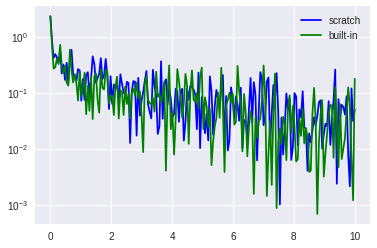

In [31]:
plt.semilogy(x_axis, losses, 'b-', label= 'scratch')
plt.semilogy(x_axis, losses1, 'g-', label= 'built-in')
plt.legend(loc= 'best')